# <div align="center">  
# Acceleration to Velocity


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kielmat.config import cfg_colors
from scipy.integrate import cumtrapz

## Insert Raw IMU Data


In [2]:
# Insert file path
csv_file_path = 'IMUS1.csv'
dataname = 'IMUS'

## CSV To TSV


In [3]:
import csv 

In [4]:
def csv_to_tsv(input_csv, output_tsv):
    with open(input_csv, 'r', newline='') as csv_file:
        csv_reader = csv.reader(csv_file)
        with open(output_tsv, 'w', newline='') as tsv_file:
            tsv_writer = csv.writer(tsv_file, delimiter='\t')
            for row in csv_reader:
                tsv_writer.writerow(row)

In [5]:
csv_to_tsv(csv_file_path, f"{dataname}.tsv")

In [6]:
file_path = f"{dataname}.tsv"

## Data Cleaning

In [7]:
sampling_frequency = 128
sampling_rate = 128
tracking_sys = "IMU"
tracked_points = {tracking_sys: ["LowerBack"]}

In [8]:
def read_and_clean_tsv(file_path, new_headers, skiprows=2):
    """
    Reads a TSV file into a DataFrame, skips rows, and assigns new headers.

    Parameters:
        file_path (str): The path to the TSV file.
        new_headers (list): A list of new column headers to assign.
        skiprows (int): The number of rows to skip from the start of the file (default is 2).

    Returns:
        pd.DataFrame: The cleaned DataFrame.
    """
    # Read the TSV file into a DataFrame with specified headers
    df = pd.read_csv(file_path, sep='\t', skiprows=skiprows, header=1)

    # Assign the new headers to the DataFrame
    df.columns = new_headers

    return df

# Example usage
new_headers = [
    'Time', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
    'Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z',
    'Magnetometer_X', 'Magnetometer_Y', 'Magnetometer_Z',
    'Barometer', 'Orientation_S', 'Orientation_X', 'Orientation_Y', 'Orientation_Z'
]
file_path = "IMUS1.tsv"
df = read_and_clean_tsv(file_path, new_headers)

# Display the shape and the first few rows of the DataFrame
df.head(5)

,Time,Accelerometer_X,Accelerometer_Y,Accelerometer_Z,Gyroscope_X,Gyroscope_Y,Gyroscope_Z,Magnetometer_X,Magnetometer_Y,Magnetometer_Z,Barometer,Orientation_S,Orientation_X,Orientation_Y,Orientation_Z
0,1.645200e+15,-9.900382,0.768888,1.488947,0.063933,0.033331,0.000101,29.908138,9.080527,15.478364,4.636850e+18,-0.764878,-0.044339,-0.642517,-0.012959
1,1.645200e+15,-9.875965,0.817546,1.549903,0.086359,0.022508,-0.015907,29.908138,9.167147,15.478988,4.636850e+18,-0.764806,-0.044544,-0.642594,-0.012686
2,1.645200e+15,-9.924262,0.817896,1.574577,0.098184,0.016069,-0.031928,29.835429,8.840564,15.588052,4.636850e+18,-0.764749,-0.044744,-0.642655,-0.012336
3,1.645200e+15,-9.900385,0.902713,1.611105,0.108872,0.005420,-0.044767,29.919711,8.607941,15.600971,4.636850e+18,-0.764717,-0.044945,-0.642687,-0.011918
4,1.645200e+15,-9.888087,0.988165,1.575027,0.115312,0.010642,-0.056525,29.920345,8.763737,15.492010,4.636850e+18,-0.764671,-0.045135,-0.642736,-0.011450


In [9]:
def import_df(dataframe,tracked_points=["lowerBack"], sample_rate=128):
    # if we have just one string, put it into a list for consistency 
    if isinstance(tracked_points, str):     
        tracked_points = [tracked_points]
        
    # dictionary to store channels
    channels_dict = {
    "name": [],
    "component": [],
    "type": [],
    "tracked_point": [],
    "units": [],
    "sampling_frequency": [],
    }

    # dictionary for the data 
    data_dict = {}

    # defining sensor types that are consistent with the other import functions 
    sensor_types = ["ACCEL", "GYRO", "MAGN", "BARO", "ORIENT"]
    # just setting units for each t
    units = {
        "ACCEL": "m/s^2",
        "GYRO": "rad/s",
        "MAGN": "µT",
        "BARO": "Pa",
        "ORIENT": "quaternion"
    }

    sample_rate = sample_rate


    for col in df.columns:
            if col == "Time":
                continue

            sensor_type = next((st for st in sensor_types if st in col.upper()), None)
            if not sensor_type:
                continue

            component = col.split('_')[-1]
            data_dict[col] = df[col]

            channels_dict["name"].append(col)
            channels_dict["component"].append(component)
            channels_dict["type"].append(sensor_type)
            channels_dict["tracked_point"].append(tracked_points[0])
            channels_dict["units"].append(units[sensor_type])
            channels_dict["sampling_frequency"].append(sample_rate)

    # Create DataFrame from data_dict
    data = pd.DataFrame(data_dict)

    # Create DataFrame from channels_dict
    channels = pd.DataFrame(channels_dict)
    return data, channels



In [10]:
data, channels = import_df(df, sample_rate=128) # this is an arbitrary sample rate that seems consistent with the examples, but I'm not sure if it is actually representative of our data

# In order to find out the real sample rate, We'd need a better/more accurate time column (I believe it got compressed and the full value isn't there )

data

acceldata = data[['Accelerometer_X','Accelerometer_Y','Accelerometer_Z']] # the input argument for the package says it needs 3 cols and only 3 cols

In [11]:
channels

,name,component,type,tracked_point,units,sampling_frequency
0,Accelerometer_X,X,ACCEL,lowerBack,m/s^2,128
1,Accelerometer_Y,Y,ACCEL,lowerBack,m/s^2,128
2,Accelerometer_Z,Z,ACCEL,lowerBack,m/s^2,128
3,Gyroscope_X,X,GYRO,lowerBack,rad/s,128
4,Gyroscope_Y,Y,GYRO,lowerBack,rad/s,128
5,Gyroscope_Z,Z,GYRO,lowerBack,rad/s,128
6,Magnetometer_X,X,MAGN,lowerBack,µT,128
7,Magnetometer_Y,Y,MAGN,lowerBack,µT,128
8,Magnetometer_Z,Z,MAGN,lowerBack,µT,128
9,Barometer,Barometer,BARO,lowerBack,Pa,128


In [12]:
acceldata

,Accelerometer_X,Accelerometer_Y,Accelerometer_Z
0,-9.900382,0.768888,1.488947
1,-9.875965,0.817546,1.549903
2,-9.924262,0.817896,1.574577
3,-9.900385,0.902713,1.611105
4,-9.888087,0.988165,1.575027
...,...,...,...
56006,-9.602051,0.542301,1.126400
56007,-9.589844,0.538983,1.142321
56008,-9.598333,0.540440,1.114593
56009,-9.619433,0.546023,1.091632


## Acceleration Plot


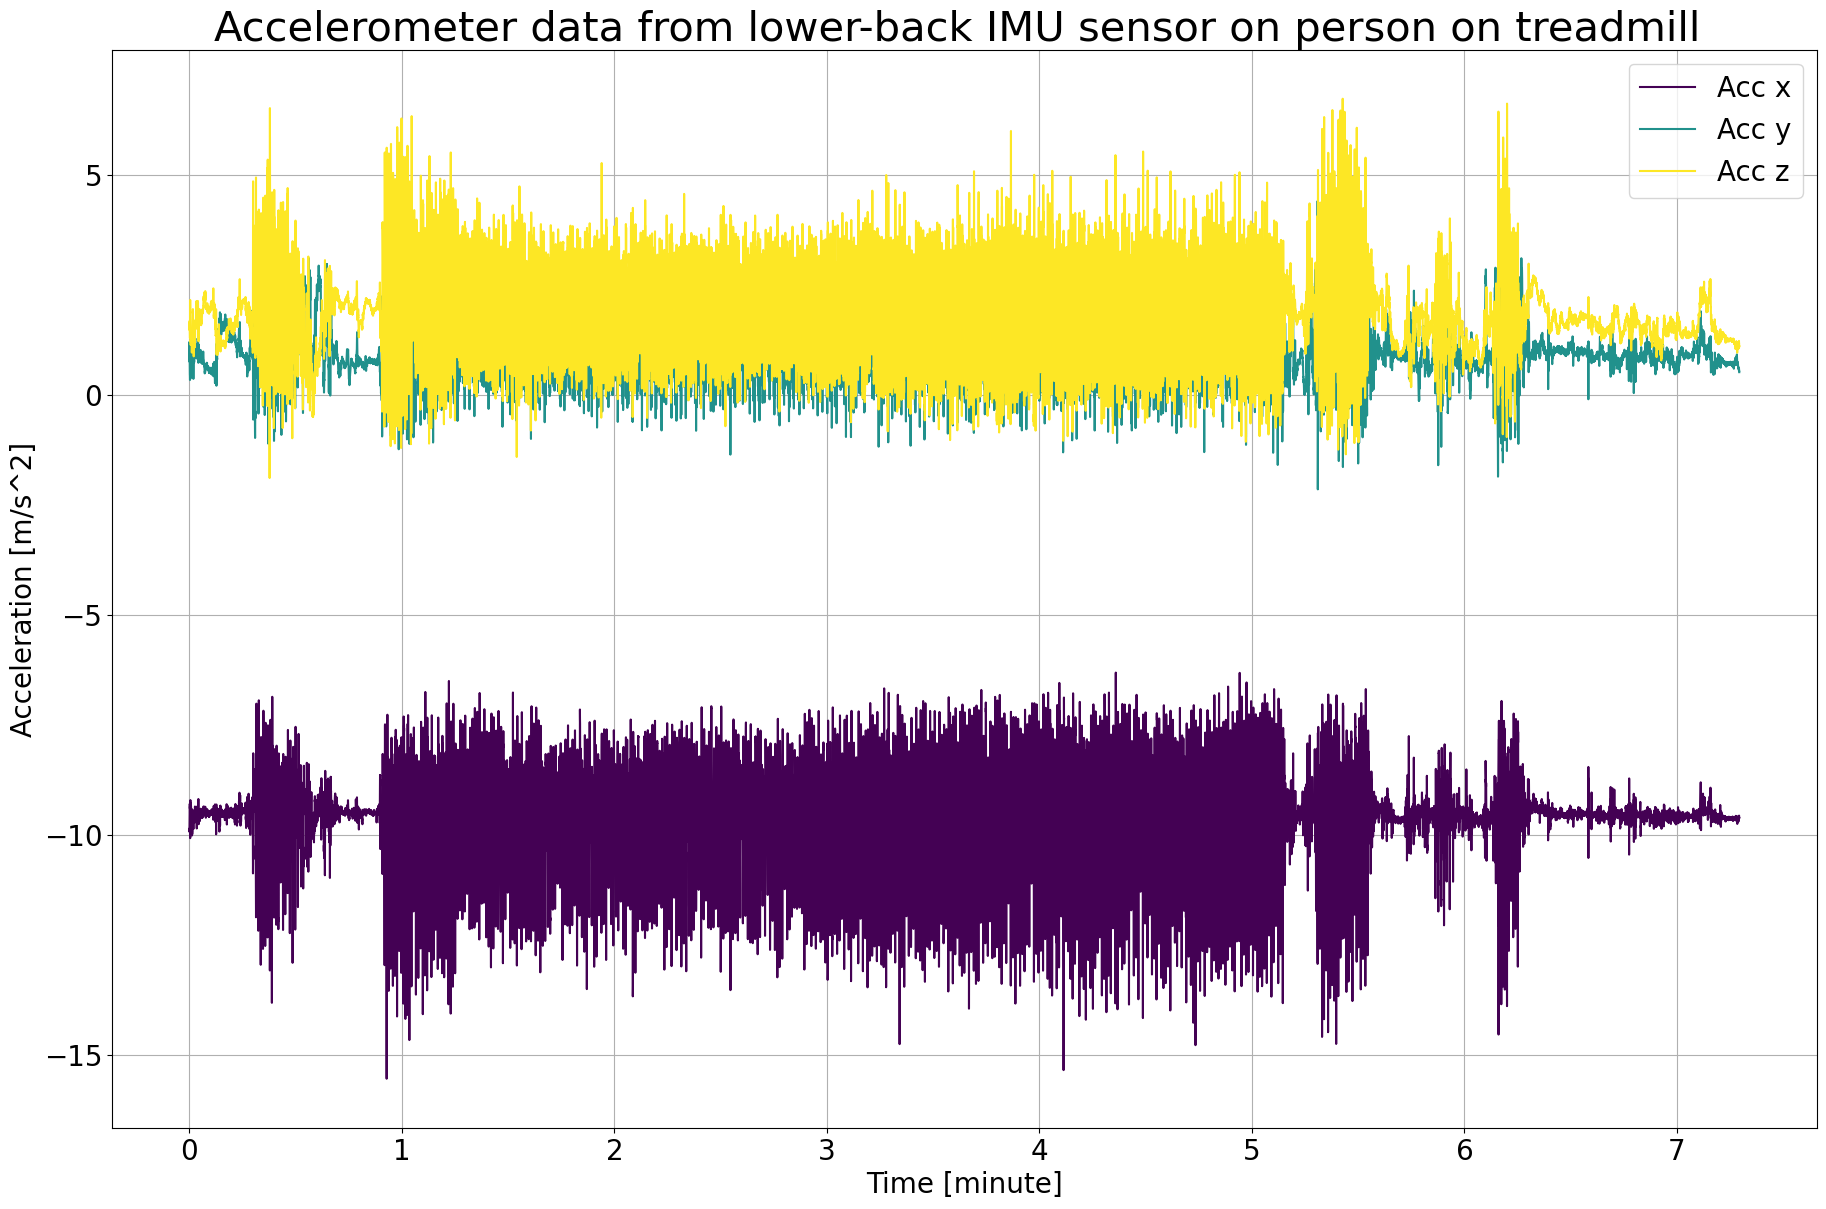

In [13]:
# Calculate the time values in minutes
# The 'time_in_minute' array represents time values in minutes, computed based on the length of 'acceleration_data' and 'sampling_frequency'.
time_in_minute = np.arange(len(acceldata)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw
colors = cfg_colors["raw"]

# A loop is used to plot data for each accelerometer axis, applying different colors from the color map.
for i in range(3):
    plt.plot(
        time_in_minute,
        acceldata[f"Accelerometer_{chr(120 + i).upper()}"],
        color=colors[i],
        label=f"Acc {'xyz'[i]}",
    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [m/s^2]", fontsize=20)
plt.legend(fontsize=20)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor on person on treadmill ",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()

### Ignore Gravity Direction and Focus Y and Z


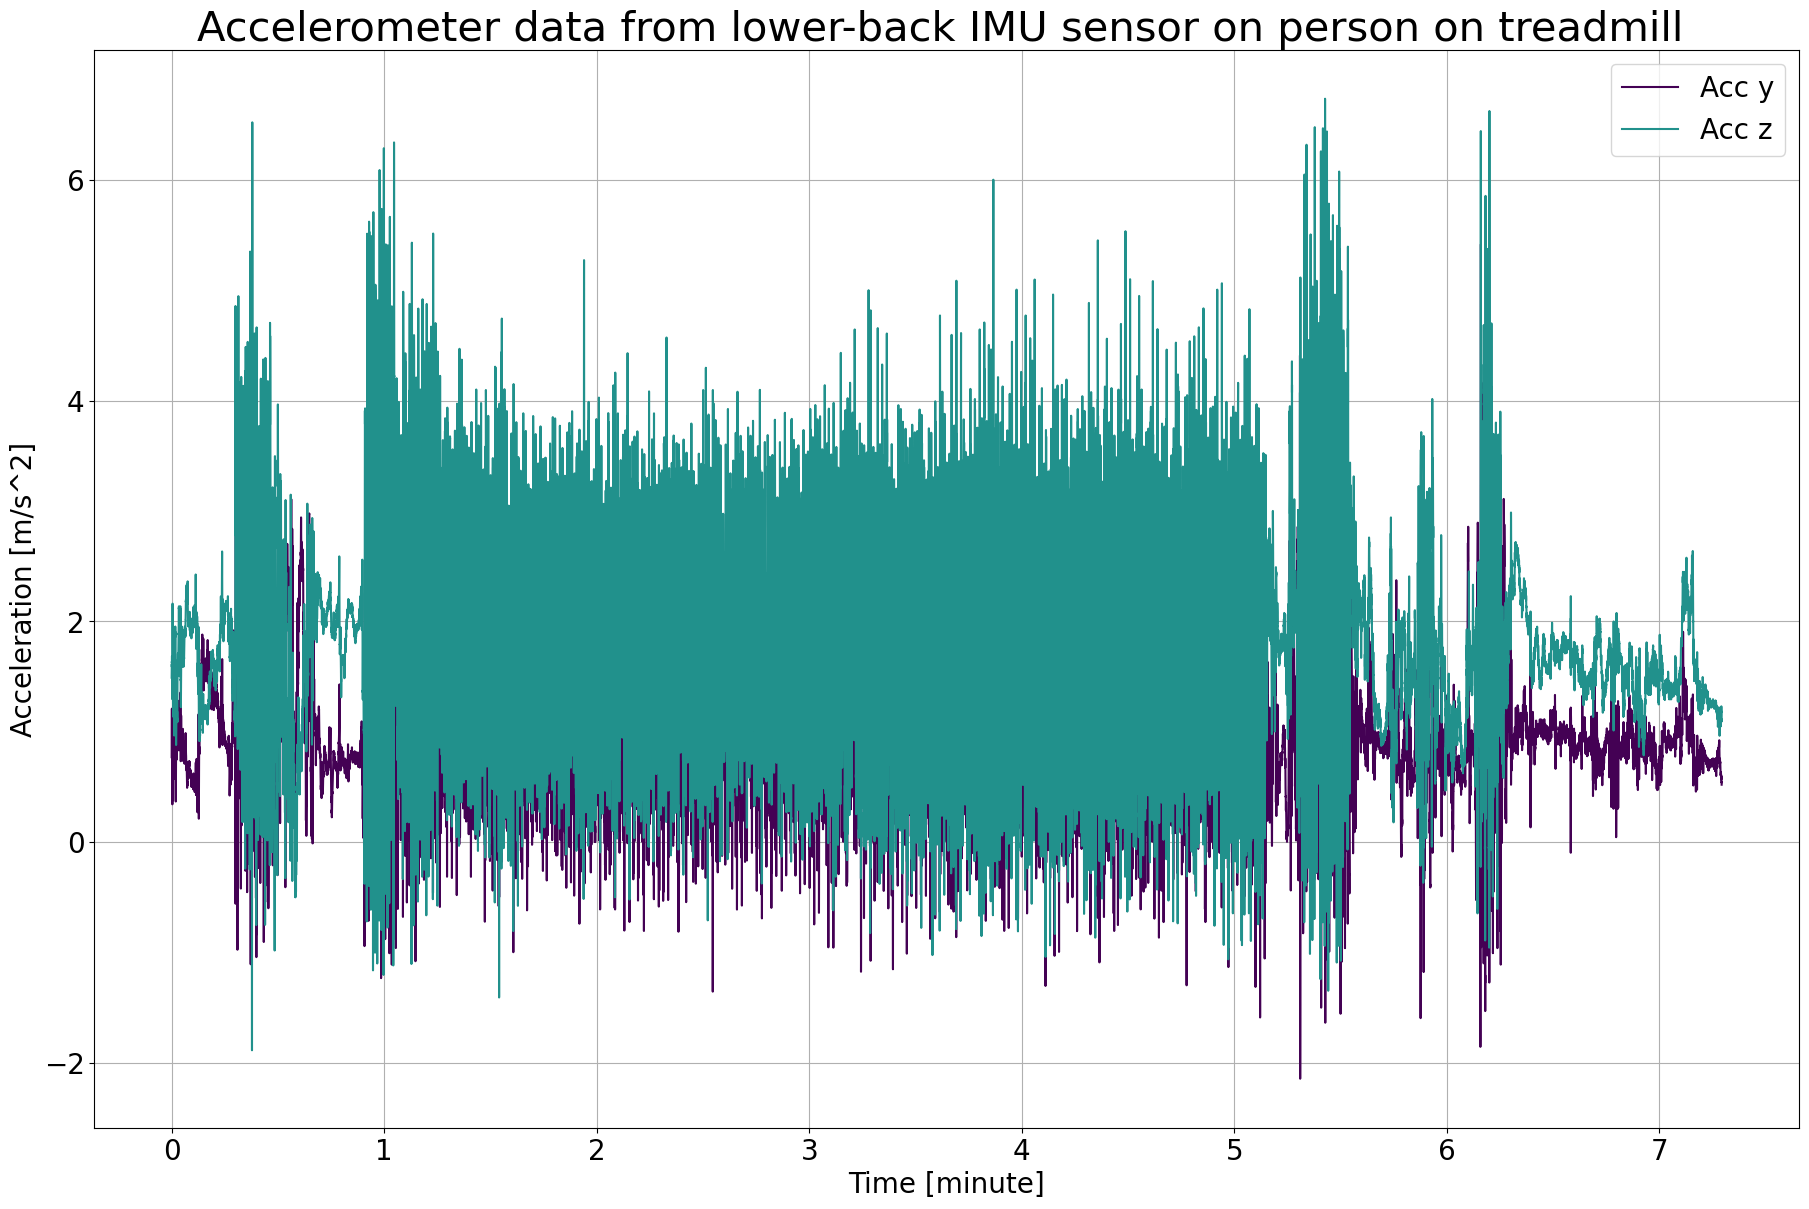

In [14]:
# Calculate the time values in minutes
time_in_minute = np.arange(len(acceldata)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(22, 14))

# Get colors for raw (assuming 'cfg_colors["raw"]' has at least 2 colors for Y and Z)
colors = cfg_colors["raw"]

# Plot data for only the y and z accelerometer axes (i = 1 and i = 2)
for i in range(1, 3):
    plt.plot(
        time_in_minute,
        acceldata[f"Accelerometer_{chr(120 + i).upper()}"],  # chr(121) -> 'Y', chr(122) -> 'Z'
        color=colors[i - 1],  # Adjust index for colors
        label=f"Acc {'yz'[i - 1]}",
    )

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [m/s^2]", fontsize=20)
plt.legend(fontsize=20)

# Add a title with a specified font size
plt.title(
    "Accelerometer data from lower-back IMU sensor on person on treadmill ",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(visible=None, which="both", axis="both")

# Show the plot
plt.show()


## Remove Accelerometer Bias


In [15]:
#Get mean of first few seconds and remove from data
def bias_removal(acceldata):
    # Create a copy of the data to avoid modifying the original DataFrame
    acceldata_clean = acceldata.copy()
    #Getting Mean of first 5 Seconds
    
    mean_accel_y = acceldata['Accelerometer_Y'].iloc[:640].mean()
    mean_accel_z = acceldata['Accelerometer_Z'].iloc[:640].mean()

    # Get the initial acceleration values for Y and Z directions (first data point)
    initial_accel_y = acceldata_clean["Accelerometer_Y"].iloc[0]
    initial_accel_z = acceldata_clean["Accelerometer_Z"].iloc[0]

    # Subtract the initial Y and Z values from the rest of the data
    acceldata_clean["Accelerometer_Y"] = acceldata_clean["Accelerometer_Y"] - mean_accel_y
    acceldata_clean["Accelerometer_Z"] = acceldata_clean["Accelerometer_Z"] - mean_accel_z

    # Return the corrected data
    return acceldata_clean

# Apply the bias removal function to clean the data
acceldata_clean = bias_removal(acceldata)

# Display the cleaned data
acceldata_clean


,Accelerometer_X,Accelerometer_Y,Accelerometer_Z
0,-9.900382,-0.093053,-0.207354
1,-9.875965,-0.044395,-0.146398
2,-9.924262,-0.044045,-0.121724
3,-9.900385,0.040772,-0.085196
4,-9.888087,0.126224,-0.121274
...,...,...,...
56006,-9.602051,-0.319640,-0.569901
56007,-9.589844,-0.322958,-0.553980
56008,-9.598333,-0.321501,-0.581708
56009,-9.619433,-0.315918,-0.604669


## Plot Clean Data


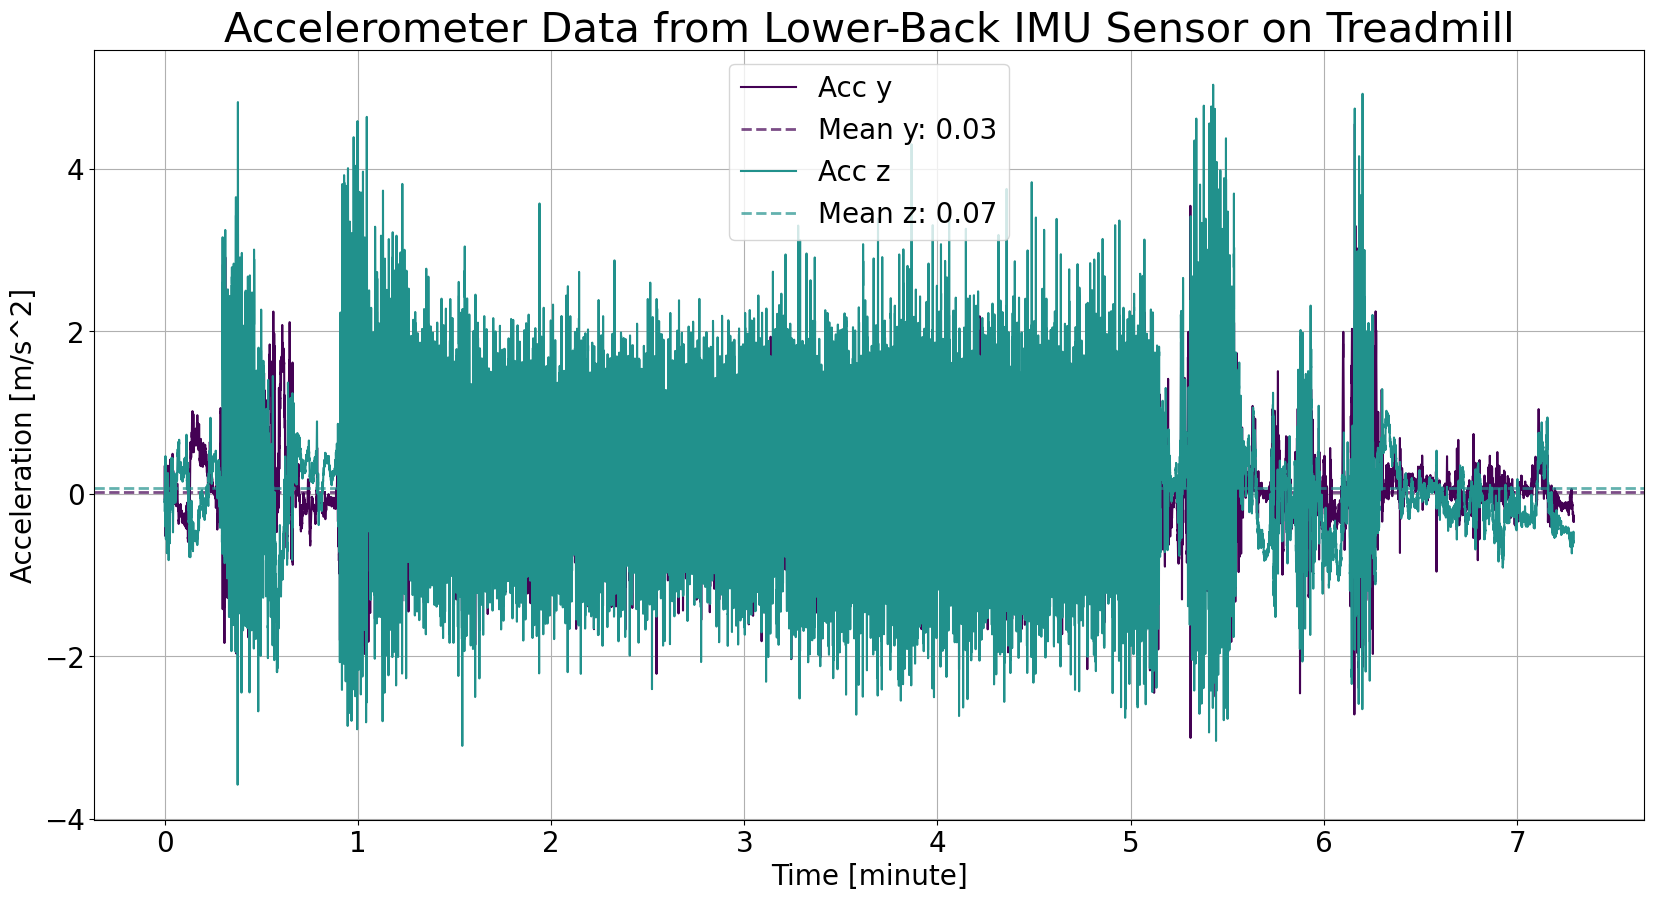

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the time values in minutes
time_in_minute = np.arange(len(acceldata_clean)) / (60 * sampling_frequency)

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Get colors for raw (assuming 'cfg_colors["raw"]' has at least 2 colors for Y and Z)
colors = cfg_colors["raw"]

# Plot data for Y and Z accelerometer axes
for i in range(1, 3):
    axis_name = f"Accelerometer_{chr(120 + i).upper()}"
    mean_value = acceldata_clean[axis_name].mean()
    
    # Plot the acceleration data
    plt.plot(
        time_in_minute,
        acceldata_clean[axis_name],
        color=colors[i - 1],
        label=f"Acc {'yz'[i - 1]}"
    )
    
    # Plot the mean line with dynamic label
    plt.axhline(y=mean_value, color=colors[i - 1], linestyle='--', linewidth=2, alpha=0.7, 
                label=f"Mean {'yz'[i - 1]}: {mean_value:.2f}")

# Add labels and legends
plt.xlabel("Time [minute]", fontsize=20)
plt.ylabel("Acceleration [m/s^2]", fontsize=20)
plt.legend(fontsize=20)

# Add a title with a specified font size
plt.title(
    "Accelerometer Data from Lower-Back IMU Sensor on Treadmill",
    fontsize=30,
)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(True)

# Show the plot
plt.show()


## Velocity Conversion


In [17]:
def accel_components_to_velocity_trapz(acceldata_clean: pd.DataFrame, sampling_frequency: float) -> pd.DataFrame:
    """
    Calculate velocity in the Y and Z directions using trapezoidal integration of acceleration data.
    
    Args:
        acceldata (pd.DataFrame): Acceleration data with columns 'Accelerometer_Y' and 'Accelerometer_Z'.
        sampling_frequency (float): Sampling frequency of the data in Hz.
    
    Returns:
        pd.DataFrame: DataFrame containing the velocity in the Y and Z directions at each sample.
    """
    if not isinstance(acceldata_clean, pd.DataFrame):
        raise TypeError("acceldata must be a pandas DataFrame.")
    
    if not all(col in acceldata.columns for col in ['Accelerometer_Y', 'Accelerometer_Z']):
        raise ValueError("DataFrame must contain 'Accelerometer_Y' and 'Accelerometer_Z' columns.")
    # Get Accel Magnitude
    accel_mag = np.sqrt(
    acceldata_clean['Accelerometer_Y']**2 + 
    acceldata_clean['Accelerometer_Z']**2
)
    # Time step (in seconds)
    dt = 1 / sampling_frequency
    
    # Initialize array to store the velocity magnitude
    velocity_mag = np.zeros(len(acceldata_clean))
    
    # Perform the trapezoidal integration to compute the velocity magnitude
    for i in range(1, len(acceldata_clean)):
        # Trapezoidal rule: v(i) = v(i-1) + (a(i) + a(i-1)) / 2 * dt
        velocity_mag[i] = velocity_mag[i-1] + (accel_mag.iloc[i] + accel_mag.iloc[i-1]) / 2 * dt
    
    # Create a DataFrame to store the velocity magnitude
    velocity_df = pd.DataFrame({
        'Velocity_Mag (m/s)': velocity_mag
    })
    
    return velocity_df


In [18]:
velo_data = accel_components_to_velocity_trapz(acceldata_clean, sampling_frequency)
velo_data

,Velocity_Mag (m/s)
0,0.000000
1,0.001485
2,0.002589
3,0.003463
4,0.004516
...,...
56006,410.675607
56007,410.680664
56008,410.685765
56009,410.691027


## Plot Velocity


In [20]:
# Define the desired time range (in minutes)
start_time = 0  # e.g., 0 minutes
end_time = 7    # e.g., 7 minutes

# Calculate the indices for the specified time range
start_idx = int(start_time * 60 * sampling_frequency)
end_idx = int(end_time * 60 * sampling_frequency)

# Slice the time and velocity magnitude data for the specified range

time_in_minute_range = time_in_minute[start_idx:end_idx]
velocity_mag_range = velocity_df['Velocity_Mag (m/s)'][start_idx:end_idx]

# Create a figure with a specified size
plt.figure(figsize=(20, 10))

# Plot velocity magnitude within the specified time range
plt.plot(time_in_minute_range, velocity_mag_range, label='Velocity Magnitude', color='purple')

# Add labels and legends
plt.xlabel("Time [minutes]", fontsize=20)
plt.ylabel("Velocity [m/s]", fontsize=20)
plt.legend(fontsize=20)

# Add a title with a specified font size
plt.title(f"Velocity Magnitude from {start_time} to {end_time} Minutes", fontsize=30)

# Customize tick font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Display a grid for reference
plt.grid(True)

# Set y-axis limits for zooming
plt.ylim(-2, 12)

# Show the plot
plt.show()





NameError: name 'velocity_df' is not defined